In [2]:
# Importing required libraries.
import time
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 
sns.set(color_codes=True)

In [3]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.drop(['Volume_(BTC)', 'Volume_(Currency)'], axis=1, inplace=True)

,Timestamp,Open,High,Low,Close,Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,58764.349363


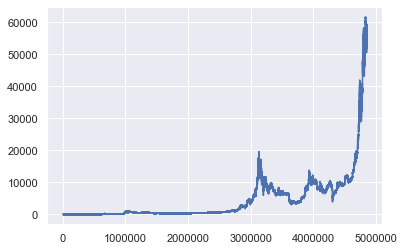

In [4]:
x = df['Timestamp']
y = df['Weighted_Price']

plt.plot(y)
df.head()
df.tail()

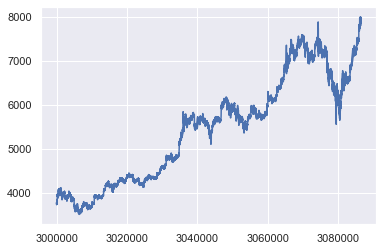

In [5]:
minutes_in_day = 24*60*60

#lower = 1445706240
lower = 3 * 10**6
upper = lower + minutes_in_day
day = df.loc[lower:upper]

prices = day['Weighted_Price']
day_length = len(day)
plt.plot(prices)

In [6]:
#moving average, most useful in up/down trends over side-to-side

def calc_mov_avg(rank, time_delta, current_index):
    average = df['Weighted_Price'][current_index-rank*time_delta:current_index].mean()
    nan_offset = rank - df['Weighted_Price'][current_index-rank*time_delta:current_index].count()
    return (average, nan_offset)

def efficient_mov_avg(prev_avg, rank, time_delta, index, nan_offset):
    old_value = df['Weighted_Price'].iloc[index-time_delta*rank-1]
    new_value = df['Weighted_Price'].iloc[index-1*time_delta]
    
    old_is_nan = np.isnan(old_value)
    new_is_nan = np.isnan(new_value)
    
    old_divisor = rank-nan_offset # accounting for prev NaN's
    
    if old_is_nan:
        old_value = 0;
        nan_offset-=1
        
    if new_is_nan:
        new_value = 0
        nan_offset+=1
        
    new_divisor = rank - nan_offset # accounting for new NaN's
    
    if new_divisor == 0: # in the event all prev values are NaN
        avg = 0
        
    else:
        avg = (prev_avg * old_divisor - old_value + new_value)/new_divisor
    
    return (avg,nan_offset)

# trade/buy

def get_curr_price(index):
    return df['Weighted_Price'].iloc[index]

def execute_buy(curr_price, cash, coin, prop):
    if cash <= 0:
        return (cash,coin)
    coin += cash*prop / curr_price
    cash -= cash*prop
    return (cash,coin)

def execute_sell(curr_price, cash, coin, prop):
    if coin <= 0:
        return (cash,coin)
    cash += coin*prop * curr_price
    coin -= coin*prop
    return (cash,coin)

# analysis

def list_assets(start_cash, cash, coin, end_index, output = True):
    end_value = get_curr_price(end_index)
    total = (end_value * coin + cash)
    delta = ( ((total-start_cash)/start_cash)*100)
    
    if output:
        print("cash: %s" % cash) 
        print("coin: %s " % coin)
        print("total value: %s" % total)
        print("percent change: %s" % delta )
        
    return delta
    
def display_data(overall_wealth, btc, cash, sample_rate, start, end, rank, time_delta):
    scaler = MinMaxScaler()
    overall_wealth = scaler.fit_transform(np.array(overall_wealth).reshape(-1,1))
    overall_btc_price = scaler.fit_transform(np.array(df['Weighted_Price'][start-rank*time_delta:end:sample_rate]).reshape(-1,1))
    btc = scaler.fit_transform(np.array(btc).reshape(-1,1))
    cash = scaler.fit_transform(np.array(cash).reshape(-1,1))
    
    
    plt.plot(df['Timestamp'][start:end:sample_rate],overall_wealth, label='overall wealth')
    plt.plot(df['Timestamp'][start-rank*time_delta:end:sample_rate],overall_btc_price, label='overall btc price')
    #plt.plot(btc, label='btc owned')
    #plt.plot(cash, label='cash on-hand')
    plt.legend(loc='best')
    plt.show()

In [7]:
starting_time = day['Timestamp'].iloc[0] 
moving_avg_rank = 200
starting_index = 3*10**6
time_delta = 1 # each increment/decrement of 1 represents one minute
#time_delta = 60 # data taken at each hour from start
#time_delta = 3600 # data taken at each day from start


# efficient moving average calculation
start_time = time.time()

res = calc_mov_avg(moving_avg_rank, time_delta, starting_index-1*time_delta) #preprocessing
prev_avg = res[0]
nan_offset = res[1]

# n = 1000 # for testing 
for i in range(starting_index, starting_index+len(day)):
    #index = starting_time + i*time_delta
    res = efficient_mov_avg(prev_avg, moving_avg_rank, time_delta, i, nan_offset)
    
    mov_avg = res[0]
    nan_offset = res[1]
    
    #if i == n:
        #print(mov_avg)
    
    prev_avg = mov_avg

    
efficient_time = time.time() - start_time


# inefficient moving average calculation
start_time = time.time()

for i in range(starting_index, starting_index+len(day)):  #for debugging, for i in range(len([i for i in range(n)])):   
    #index = starting_time + i*time_delta
    mov_avg = calc_mov_avg(moving_avg_rank, time_delta, i)[0]
    
    #if i == n:
        #print(mov_avg)

    
inefficient_time = time.time() - start_time


print("efficient: %s seconds" % efficient_time)
print("in-efficient: %s seconds" % inefficient_time)
print("time saved: %s seconds" % (inefficient_time-efficient_time))

efficient: 3.284182071685791 seconds
in-efficient: 31.922975778579712 seconds
time saved: 28.63879370689392 seconds


In [9]:
#For verification of accuracy of calculating moving averages

a = np.array([element+.25*element for element in range(20)])


def calc_mov_avg(rank, time_delta, current_index):
    average = a[current_index-rank*time_delta:current_index].mean()
    return average

def efficient_mov_avg(prev_avg, rank, time_delta, index):
    old_value = a[index-time_delta*rank-1]
    new_value = a[index-1*time_delta]
    
    old_value = 0 if np.isnan(old_value) else old_value
    new_value = 0 if np.isnan(new_value) else new_value
    avg = (prev_avg * rank - old_value + new_value)/rank
    
    return avg

prev_avg = 4.375
real = calc_mov_avg(4,1,7)
eff = efficient_mov_avg(prev_avg, 4,1,7)

print(real)
print(eff)

5.625
5.625


cash: 0.0
coin: 0.25490786541766447 
total value: 1024.6602143987886
percent change: 2.466021439878864


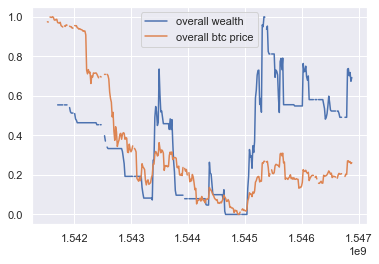

In [242]:
#buy when above, sell when below
#golden cross (50 day crosses above 200 day, bearish to bullish) vs death cross

start_cash = 1000
cash = 1000
coin = 0
buy = 0
sell = 0
    
start = int(3.6 * 10**6 + 0*len(day))
end = start + len(day)
rank = 50
time_delta = 60 #1, 60, 3600 for minutes, hours, days, respectively

res = calc_mov_avg(rank, time_delta, start-1*time_delta) #preprocessing
prev_avg = res[0]
nan_offset = res[1]

sample_rate = 250
btc_value_dollars = [float] * (int(len(day) / sample_rate)+1)
cash_value_dollars = [float] * (int(len(day) / sample_rate)+1)
overall_wealth = [float] * (int(len(day) / sample_rate)+1)

buy_proportion = 1
sell_proportion = 1
arr_index = 0
for i in range(start, end):
    
    res = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset)
    curr_price = get_curr_price(i)
    mov_avg = res[0]
    nan_offset = res[1]
    prev_avg = mov_avg 
    
    if curr_price > mov_avg: #handles NaN
        buy+=1
        res = execute_buy(curr_price, cash, coin, buy_proportion)
        cash = res[0]
        coin = res[1]
    elif curr_price < mov_avg: #handles NaN
        sell+=1
        res = execute_sell(curr_price, cash, coin, sell_proportion)
        cash = res[0]
        coin = res[1]

    if (i-start) % sample_rate == 0:
        btc_value_dollars[arr_index] = coin * curr_price
        cash_value_dollars[arr_index] = cash
        overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
        arr_index+=1
list_assets(start_cash, cash, coin, end)
display_data(overall_wealth, btc_value_dollars, cash_value_dollars, sample_rate, start, end, rank, time_delta)

(0.01, '34.7%')
(0.02, '59.6322%')
(0.03, '53.6482%')
(0.04, '32.2439%')
(0.05, '104.0986%')
(0.06, '69.2077%')
(0.07, '60.162%')
(0.08, '68.837%')
(0.09, '79.914%')
(0.1, '75.6007%')


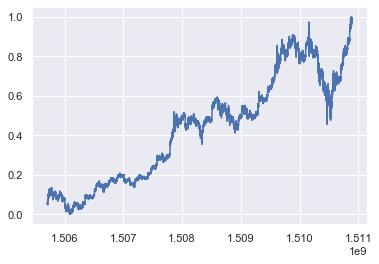

In [12]:
#simple buying and selling when percentage threshold is met

def calc_thresholds(index, trigger_threshold):
    reference_price = get_curr_price(index)
    sell = (1 + trigger_threshold) * reference_price
    buy = (1 - trigger_threshold) * reference_price
    return (reference_price, sell, buy)
    
start = int(3 * 10**6 + 0*len(day))
end = start + len(day)

sample_rate = 250
btc_value_dollars = [float] * (int(len(day) / sample_rate)+1)
cash_value_dollars = [float] * (int(len(day) / sample_rate)+1)
overall_wealth = [float] * (int(len(day) / sample_rate)+1)

buy_proportion = 1
sell_proportion = 1

trigger_thresholds = [el/100 for el in range(1,11)]
deltas = [float] * len(trigger_thresholds)
deltas_index = 0

for trigger_threshold in trigger_thresholds:
    start_cash = 1000
    cash = 1000
    coin = 0
    buy = 0
    sell = 0
    arr_index = 0
    
    reference_price, sell_threshold, buy_threshold = calc_thresholds(start-1, trigger_threshold)

    for i in range(start, end):

        curr_price = get_curr_price(i)


        if curr_price >= sell_threshold: #handles NaN
            buy+=1
            res = execute_buy(curr_price, cash, coin, buy_proportion)
            cash = res[0]
            coin = res[1]
            reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)
        elif curr_price <= buy_threshold: #handles NaN
            sell+=1
            res = execute_sell(curr_price, cash, coin, sell_proportion)
            cash = res[0]
            coin = res[1]
            reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)

        if (i-start) % sample_rate == 0:
            btc_value_dollars[arr_index] = coin * curr_price
            cash_value_dollars[arr_index] = cash
            overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
            arr_index+=1

    deltas[deltas_index] = list_assets(start_cash, cash, coin, end, output=False)
    deltas_index+=1


for i in range(len(trigger_thresholds)):   
    print((trigger_thresholds[i],f'{round(deltas[i],4)}%'))

scaler = MinMaxScaler()
overall_btc_price = scaler.fit_transform(np.array(df['Weighted_Price'][start-1:end]).reshape(-1,1))
plt.plot(df['Timestamp'][start-1:end],overall_btc_price, label='overall btc price')